# CS361 Group Assignment

Group Members: Lucy Harris (lhar917), Hayley Sharpe (hsha609), Kunal Bhaskar (kbha962), Jackson Fontaine (jfon971), Seth Gousmett (sgou398)

## Task 1

(a) Load the dataset and construct a feature vector for each article in the entire dataset. You
need to report the number of articles, and the number of extracted features. Show 5 example
articles with their extracted features using a dataframe.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def make_df():
    df = pd.read_csv("../train.csv")
    return df

def main():
    data = make_df()
    print("Length of data: ", len(data))
    print("Number of features per example (number of extracted features):", len(data.columns))
    print("First 5 example articles:")
    print(data.head())

    words_dict, entertainment_dict, tech_dict, tech_entertainment = feature_analyse(data)

def feature_analyse(data):
    tech_dict = {}
    entertainment_dict = {}
    tech_entertainment = [0, 0]
    
    words_dict = {}
    for index, row in data.iterrows():
        words = row["Text"].split()
        category = row["Category"]

        if category == "tech":
            tech_entertainment[0] += 1

        else:
            tech_entertainment[1] += 1

        for word in words:

            if word not in tech_dict and category=="tech":
                tech_dict[word] = 1
            elif category=="tech":
                tech_dict[word] += 1

            if word not in entertainment_dict and category=="entertainment":
                entertainment_dict[word] = 1
            elif category=="entertainment":
                entertainment_dict[word] += 1
                    
            if word not in words_dict:
                words_dict[word] = 1
            else:
                words_dict[word] += 1


    return words_dict, entertainment_dict, tech_dict, tech_entertainment

main()

Length of data:  428
Number of features per example (number of extracted features): 3
First 5 example articles:
   ArticleId                                               Text       Category
0       1976  lifestyle governs mobile choice faster better ...           tech
1       1797  french honour director parker british film dir...  entertainment
2       1866  fockers fuel festive film chart comedy meet fo...  entertainment
3       1153  housewives lift channel 4 ratings debut us tel...  entertainment
4        342  u2 desire number one u2 three prestigious gram...  entertainment


(b) Conduct term frequency analysis and report three plots: (i) top-50 term frequency distribution
across the entire dataset, (ii) term frequency distribution for respective class of articles, and (iii)
class distribution.

Length of data:  428
Number of features per example (number of extracted features): 3
First 5 example articles:
   ArticleId                                               Text       Category
0       1976  lifestyle governs mobile choice faster better ...           tech
1       1797  french honour director parker british film dir...  entertainment
2       1866  fockers fuel festive film chart comedy meet fo...  entertainment
3       1153  housewives lift channel 4 ratings debut us tel...  entertainment
4        342  u2 desire number one u2 three prestigious gram...  entertainment


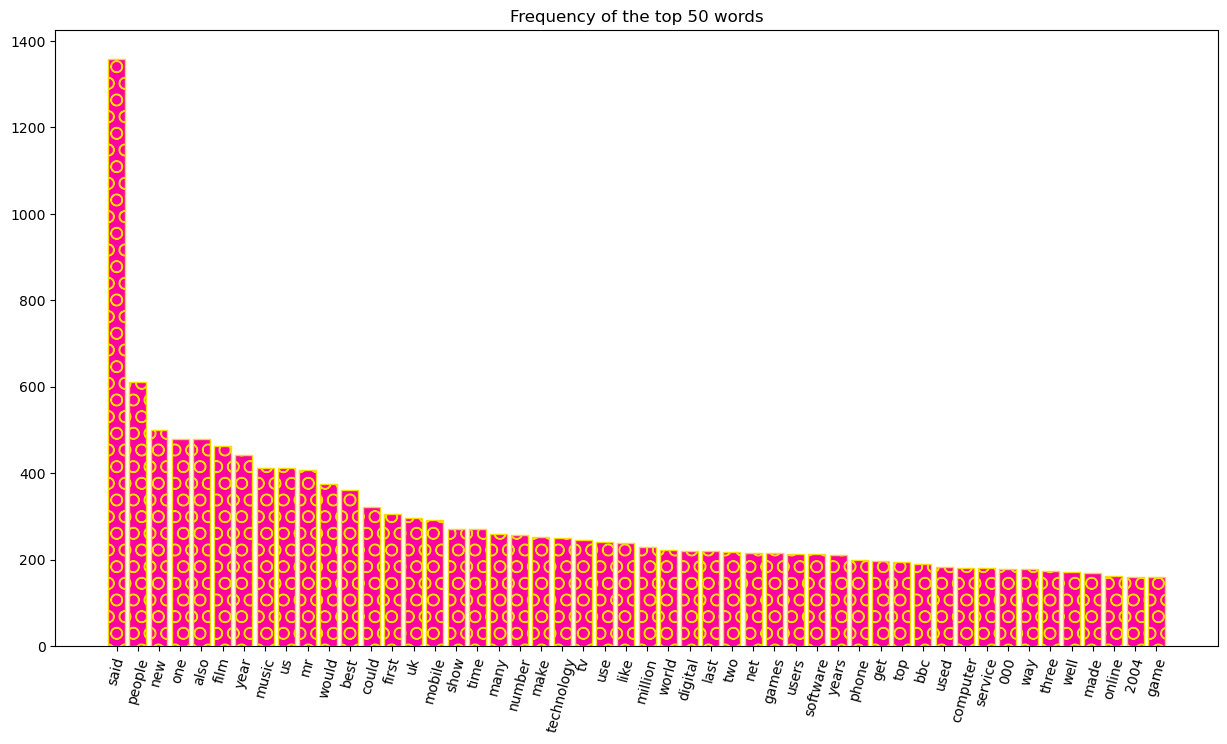

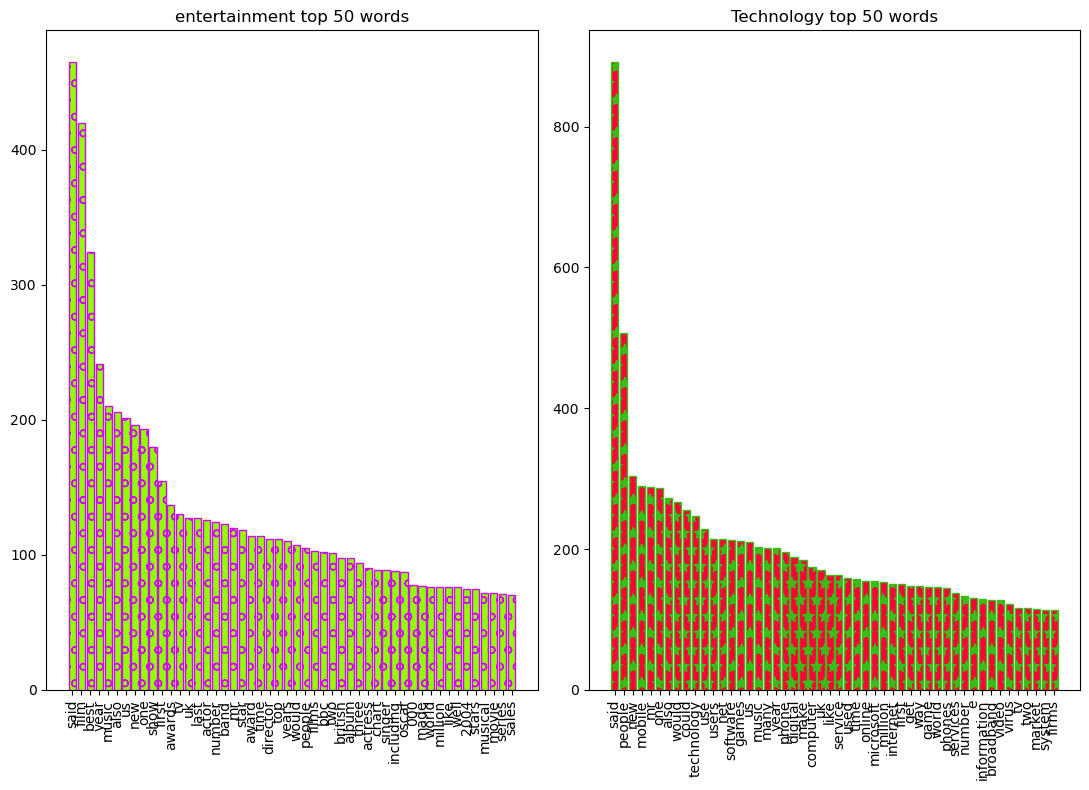

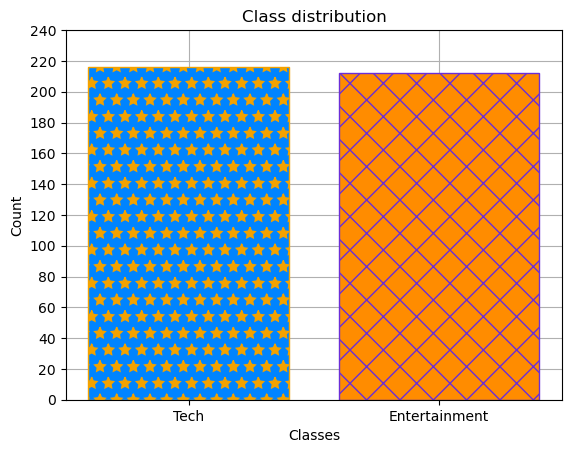

In [4]:
def main():
    data = make_df()
    print("Length of data: ", len(data))
    print("Number of features per example (number of extracted features):", len(data.columns))
    print("First 5 example articles:")
    print(data.head())

    words_dict, entertainment_dict, tech_dict, tech_entertainment = feature_analyse(data)
    
    # overall words top 50 plot
    top50_barplot(words_dict)

    top50_per_class(entertainment_dict, tech_dict)

    class_dist(tech_entertainment)

def make_df():
    df = pd.read_csv("../train.csv")
    return df

# Plots the top 50 words across all training instances
def top50_barplot(words_dict):
    # list of words
    top_50_words = sorted(words_dict.items(), key = lambda item:item[1], reverse= True)[:50]

    # turning back into dict
    top_50_dict = dict(top_50_words)

    plt.figure(figsize=(15, 8))
    bars6 = plt.bar(top_50_dict.keys(), top_50_dict.values(), width=0.8, color = "#FF00A2", edgecolor = "#fcdb03")
    plt.xticks(rotation = 75)
    plt.title("Frequency of the top 50 words")

    pattenr = ["O"] * 50

    for bar, pattern in zip(bars6, pattenr):
        bar.set_hatch(pattern)
    
    plt.show()
    
# Plots the distribution of classes in the training dataset
def class_dist(tech_entertainment):
    fig, ax = plt.subplots()    
    
    ax.grid(True)
    ax.set_axisbelow(True)
    bars = ax.bar(["Tech",  "Entertainment"], tech_entertainment, color = ["#0084FF", "#ff8c00"], width=0.8, edgecolor = ["#f3a200", "#6b2ed7"])
    ax.set_yticks(range(0,250, 20))
    ax.set_title("Class distribution")
    ax.set_xlabel("Classes")
    ax.set_ylabel("Count")

    patterns = ["*", "x"]

    for bar, pattern in zip(bars, patterns):
        bar.set_hatch(pattern)

    plt.show()
    
# Plots the top 50 words for each of the two classes in the training dataset
def top50_per_class(entertainment_dict, tech_dict):
    top_50_words_entertainment = sorted(entertainment_dict.items(), key = lambda item:item[1], reverse= True)[:50]

    # turning back into dict entertainment edition
    top_50_dict_entertainment = dict(top_50_words_entertainment)

    # tech dict
    top_50_words_tech = sorted(tech_dict.items(), key = lambda item:item[1], reverse= True)[:50]

    # turning back into dict
    top_50_dict_tech = dict(top_50_words_tech)

    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(11, 8))

    #entertainment plot
    bars0 = axes[0].bar(top_50_dict_entertainment.keys(), top_50_dict_entertainment.values(), width=0.8, color = "#91FF00", edgecolor = "#d106f3")
    axes[0].set_title("entertainment top 50 words")
    axes[0].tick_params(axis = 'x', rotation = 90)
    
    #tech plot
    bars1 = axes[1].bar(top_50_dict_tech.keys(), top_50_dict_tech.values(), width=0.8, color = "#FF0037", edgecolor = "#39be19")
    axes[1].set_title("Technology top 50 words")
    axes[1].tick_params(axis = 'x', rotation = 90)

    fig.tight_layout()

    patterns = ["*"] * 50

    for bar, pattern in zip(bars1, patterns):
        bar.set_hatch(pattern)

    patterns2 = ["o"] * 50
    
    for bar, pattern in zip(bars0, patterns2):
        bar.set_hatch(pattern)
        
    plt.show()

main()

## Task 2

#### Part A - Naive Bayes

#### Part B - K-Nearest Neighbors

#### Part C - Support Vector Machine

#### Part D - Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np

def main():
    data = make_df("../../train.csv")
    y = data["Category"]
    test_data = make_df("../../test.csv")
    vector, vector_test = vectorize(data, test_data)

    cels = []
    num_nods = [5, 20, 40]
    for num in num_nods:
        probs, clf = make_classifier(vector, y, vector_test, num)
        cels.append(np.mean(clf.loss_curve_))

    plt.plot(num_nods, cels, marker = "*", color = "#F543BA", markersize = 10)
    plt.xlabel("number of nodes per layer")
    plt.ylabel("Cross entropy loss")
    plt.title("Cross entropy loss by number of nodes per layer")
    plt.show()
    
def vectorize(data, test_data):
    vectorizer = CountVectorizer()
    vectorizer.fit(data["Text"])
    vector = vectorizer.transform(data["Text"])
    test_vector = vectorizer.transform(test_data["Text"])
    return vector, test_vector

def make_df(filename):
    return pd.read_csv(filename)

def make_classifier(vector, y, vector_test, num_nodes = 5):
    # creating the untrained model
    clf = MLPClassifier(activation = 'relu',
                        solver = 'sgd',
                        learning_rate_init = 0.01,
                        max_iter = 100,
                        hidden_layer_sizes = (num_nodes,))

    # initialise weights
    clf.partial_fit(vector, y, classes=np.unique(y))

    # manually set weights to [0, 0.1]
    for i in range(len(clf.coefs_)):
        clf.coefs_[i] = np.random.uniform(0, 0.1, size=clf.coefs_[i].shape)
    for i in range(len(clf.intercepts_)): 
        clf.intercepts_[i] = np.random.uniform(0, 0.1, size=clf.intercepts_[i].shape)

    # training
    clf.fit(vector, y)

    probs = clf.predict_proba(vector_test)

    return probs, clf

main()

## Task 3

#### Part A - Training/Validation Proportion Parameter

Neural Networks:

In [ ]:
def main():
    data = make_df("../../train.csv")
    y = data["Category"]
    test_data = make_df("../../test.csv")
    y_test = test_data["Category"]       
    vector, vector_test = vectorize(data, test_data)

    test_f1s = []
    train_f1s = []
    ms = [0.1, 0.3, 0.5, 0.7, 0.9]
    for m in ms:
        train_f1, test_f1 = train_on_m(y, vector, vector_test, m, y_test)
        test_f1s.append(test_f1)
        train_f1s.append(train_f1)

    plt.plot(ms, test_f1s, marker = "o", color = "#BA52FF", markersize = 7)
    plt.title("Test F1 Scores")
    plt.xlabel("m Values")
    plt.ylabel("F1 score")
    plt.show()

    plt.plot(ms, train_f1s, marker = "x", color = "#F431CB", markersize = 8)
    plt.title("Train F1 Scores")
    plt.xlabel("m Values")
    plt.ylabel("F1 score")
    plt.show()
    
def train_on_m(train_y, vector, vector_test, m, y_test):
    sub_vector = vector[0:round(vector.shape[0]*m)]
    
    probs, clf = make_classifier(sub_vector, train_y[0:round(len(train_y)*m)], vector_test)

    preds_test = clf.predict(vector_test)
    preds_train = clf.predict(sub_vector)

    train_f1 = calc_f1(preds_train, train_y)
    test_f1 = calc_f1(preds_test, y_test)

    return train_f1, test_f1

def calc_f1(preds, actual):
    tp = 0
    fp = 0
    fn = 0
    tn = 0

# Consider tech to be the positive class
    for i in range(len(preds)):
        if preds[i] == "tech" and actual[i] == "tech":
            tp += 1
        elif preds[i] == "tech" and actual[i] == "entertainment":
            fp += 1
        elif preds[i] == "entertainment" and actual[i] == "entertainment":
            tn += 1
        else:
            fn += 1

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2*((precision*recall) / (precision+recall))

    return f1

main()

#### Part B - 5-Fold Cross-Validation Model Performance Assessments

Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

def vectorize(data, test_data):
    vectorizer = CountVectorizer()
    vectorizer.fit(data["Text"])
    vector = vectorizer.transform(data["Text"])
    test_vector = vectorizer.transform(test_data["Text"])

    return vector, test_vector

def make_df(filename):
    return pd.read_csv(filename)

def main():
    data = make_df("../../train.csv")
    y = data["Category"]
    test_data = make_df("../../test.csv")
    y_test = test_data["Category"]       
    vector, vector_test = vectorize(data, test_data)
    probs, model = make_classifier(vector, y, vector_test)

    cross_validate(model, vector, y, vector_test, y_test)

def make_classifier(vector, y, vector_test, num_nodes = 5):
    # creating the untrained model
    clf = MLPClassifier(activation = 'relu',
                        solver = 'sgd',
                        learning_rate_init = 0.01,
                        max_iter = 100,
                        hidden_layer_sizes = (num_nodes,))

    # initialise weights
    clf.partial_fit(vector, y, classes=np.unique(y))

    # manually set weights to [0, 0.1]
    for i in range(len(clf.coefs_)):
        clf.coefs_[i] = np.random.uniform(0, 0.1, size=clf.coefs_[i].shape)
    for i in range(len(clf.intercepts_)): 
        clf.intercepts_[i] = np.random.uniform(0, 0.1, size=clf.intercepts_[i].shape)

    # training
    clf.fit(vector, y)

    probs = clf.predict_proba(vector_test)
    return probs, clf

def cross_validate(clf, train_descriptions, train_y, test_descriptions, test_y):
    scores = cross_val_score(clf, train_descriptions, train_y, cv=5, scoring="f1_macro")
    print("Scores for normal classifier:", scores, "with average", str(sum(scores) / len(scores)))

    # calculating learning rate accuracy scores
    learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.75, 1, 2, 5]
    for learning_rate in learning_rates:
        # retrain clf
        clf = MLPClassifier(activation = 'relu', solver = 'sgd', learning_rate_init = learning_rate,
                        max_iter = 100, hidden_layer_sizes = (5,)).fit(train_descriptions, train_y)
        get_scores(clf, test_descriptions, test_y, "learning rate", learning_rate)

    # calculating epoch count accuracy scores
    max_iter_values = [5, 50, 100, 200, 500, 1000, 5000]
    for max_iter_val in max_iter_values:
        # retrain clf
        clf = MLPClassifier(activation = 'relu', solver = 'sgd', learning_rate_init = 0.01,
                        max_iter = max_iter_val, hidden_layer_sizes = (5,)).fit(train_descriptions, train_y)
        get_scores(clf, test_descriptions, test_y, "max iterations", max_iter_val)

    # calculating activation function accuracy scores
    activation_functions = ["relu", "identity", "logistic", "tanh"]
    for function in activation_functions:
        # retrain clf
        clf = MLPClassifier(activation = function, solver = 'sgd', learning_rate_init = 0.01,
                        max_iter = 100, hidden_layer_sizes = (5,)).fit(train_descriptions, train_y)
        get_scores(clf, test_descriptions, test_y, "activation function", function)

    # calculating hidden layer count accuracy scores
    num_layers = [1, 2, 3, 4, 5, 10, 20, 40]
    for num in num_layers:
        # retrain clf
        sizes = (5,) * num
        clf = MLPClassifier(activation = 'relu', solver = 'sgd', learning_rate_init = 0.01,
                        max_iter = 100, hidden_layer_sizes = sizes).fit(train_descriptions, train_y)
        get_scores(clf, test_descriptions, test_y, "number of layers = ", num)

    # taking subset of the best epochs and learning rates, and finding best accuracy for this
    max_iter_values = [100, 200, 500, 1000, 5000]
    learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
    for iter_val in max_iter_values:
        for learning_rate in learning_rates:
        # retrain clf for each combo of learning rate and max iter
            clf = MLPClassifier(activation = 'relu', solver = 'sgd', learning_rate_init = learning_rate,
                            max_iter = iter_val, hidden_layer_sizes = 2).fit(train_descriptions, train_y)
            get_scores(clf, test_descriptions, test_y, f"Max iterations = {iter_val},", f"learning rate = {learning_rate}") # change this text


def get_scores(clf, test_descriptions, test_y, hyperparam, value):
        scores = cross_val_score(clf, test_descriptions, test_y, cv=5, scoring="f1_macro")
        avg = sum(scores) / len(scores)
        # UNCOMMENT THIS PRINT TO SEE CV SCORES AND AVERAGES
        # print(f"Score for {hyperparam} {value}:", scores, "with average", str(avg))

main()

#### Part C - Report and Compare Classifiers